In [1]:
import alpaca_trade_api as tradeapi
import pandas as pd
from datetime import datetime, timedelta
from utils_day_trade import backtest_plot

In [2]:
import alpaca_trade_api as tradeapi

API_KEY = 'PK55SJLN5X7L81OB9D1P'
SECRET_KEY = '3iWrQIdPWUlbNFV1wNcBzGx2JReYbMEQOXtx9rH0'
BASE_URL = 'https://paper-api.alpaca.markets'  # for paper trading

api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

# Get your account info
account = api.get_account()
print(account.status)


ACTIVE


In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

start_date_str = '2025-07-01' # '2025-01-07' #

# ✅ 修复 RFC3339 格式要求：无微秒、带 Z 时区后缀
end_date_str = datetime.utcnow().replace(microsecond=0).isoformat() + 'Z'
ticker = "TQQQ"
bars = api.get_bars(
    symbol=ticker,
    timeframe='5Min',
    start=start_date_str,
    end=end_date_str,
    feed = 'iex'
).df

# 如果是 MultiIndex
if isinstance(bars.index, pd.MultiIndex):
    bars = bars[bars.index.get_level_values('symbol') == ticker]

print(bars.tail())

                           close   high    low  trade_count   open  volume  \
timestamp                                                                    
2025-07-07 20:05:00+00:00  82.63  82.70  82.62            4  82.70     700   
2025-07-07 20:10:00+00:00  82.66  82.66  82.60            3  82.60     367   
2025-07-07 20:25:00+00:00  82.68  82.68  82.68            1  82.68     170   
2025-07-07 20:35:00+00:00  82.50  82.53  82.50            3  82.53     806   
2025-07-07 20:40:00+00:00  82.31  82.43  82.31            4  82.43     835   

                                vwap  
timestamp                             
2025-07-07 20:05:00+00:00  82.635714  
2025-07-07 20:10:00+00:00  82.643516  
2025-07-07 20:25:00+00:00  82.680000  
2025-07-07 20:35:00+00:00  82.515000  
2025-07-07 20:40:00+00:00  82.370000  


In [4]:
# import yfinance as yf
# import pandas as pd
# import matplotlib.pyplot as plt
# ticker = "TQQQ"
# api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')
# start_date_str = '2025-04-07'
# end_date_str = '2025-07-06'
# #start_date_str = start_date.date().isoformat()  # e.g. "2025-06-07"
# #end_date_str = end_date.date().isoformat()

# bars = api.get_bars(
#     symbol=ticker,
#     timeframe='5Min',
#     start=start_date_str,
#     end=end_date_str
# ).df
# print(bars.tail())
# # 设置股票代码



In [5]:
# 下载 5 天的 5分钟级数据
data = bars
df = data.reset_index()
print('lastest time')
print(list(df['timestamp'])[-1])

lastest time
2025-07-07 20:40:00+00:00


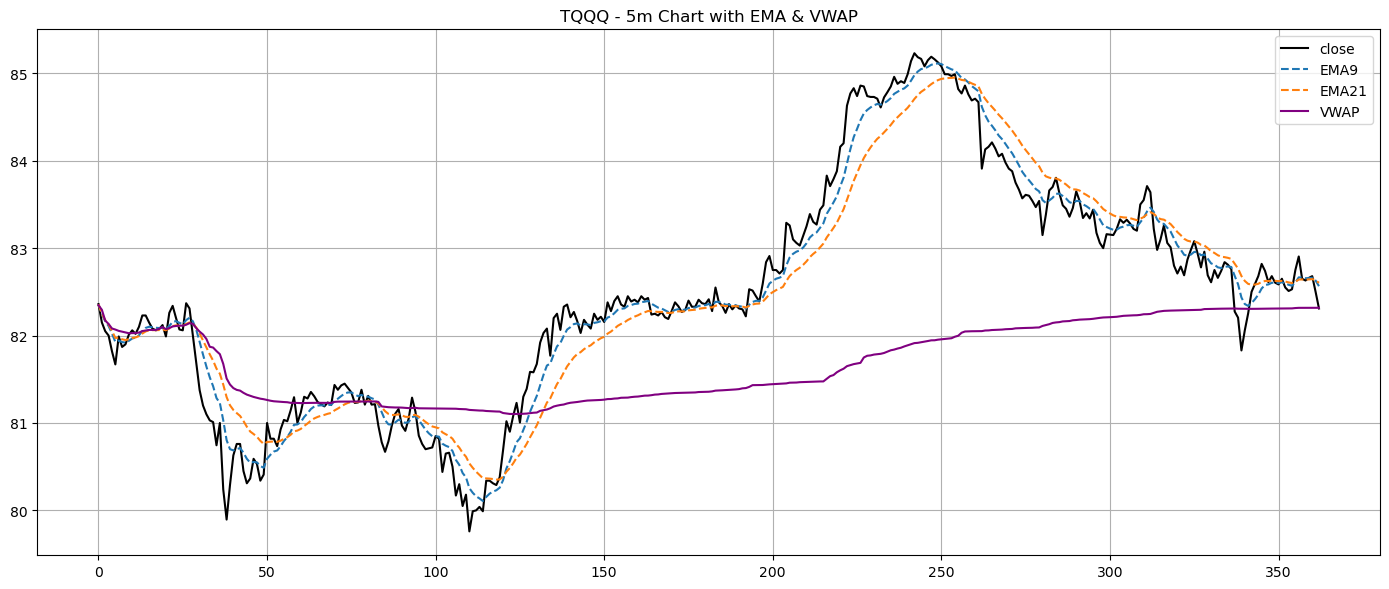

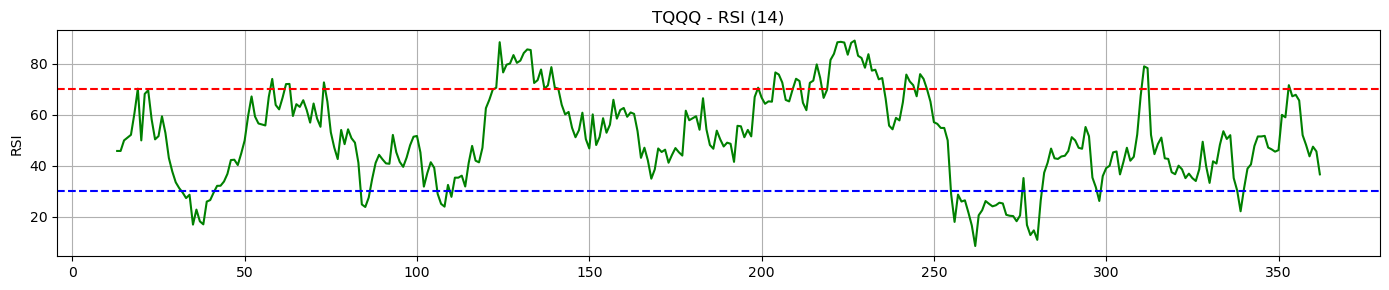

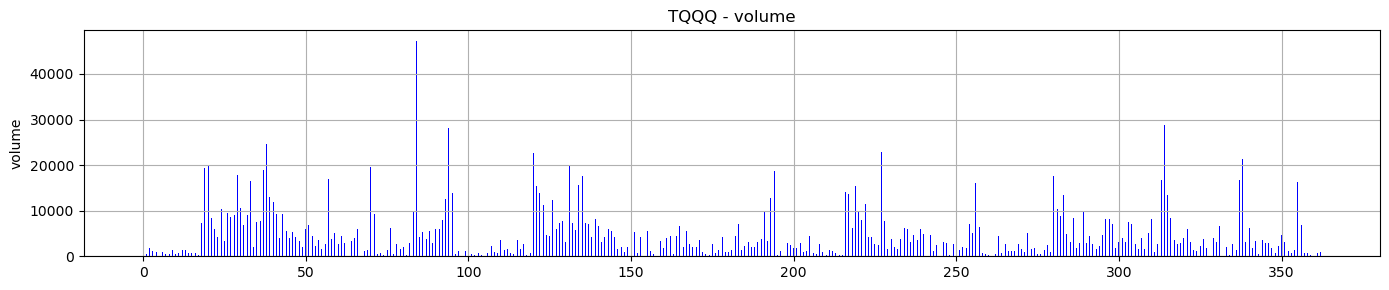

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt



# 下载 5 天的 5分钟级数据
# data = yf.download(ticker, interval="5m", period="max")
#df = data.reset_index().droplevel(1, axis=1)
# 计算技术指标
df["EMA9"] = df["close"].ewm(span=9).mean()
df["EMA21"] = df["close"].ewm(span=21).mean()

# RSI
delta = df["close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# VWAP
df["Typical_Price"] = (df["high"] + df["low"] + df["close"]) / 3
df["Cum_TP_Vol"] = (df["Typical_Price"] * df["volume"]).cumsum()
df["Cum_volume"] = df["volume"].cumsum()
df["VWAP"] = df["Cum_TP_Vol"] / df["Cum_volume"]

# 主图
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="close", color="black")
plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
plt.title(f"{ticker} - 5m Chart with EMA & VWAP")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# RSI 图
plt.figure(figsize=(14, 3))
plt.plot(df.index, df["RSI"], label="RSI", color="green")
plt.axhline(70, color="red", linestyle="--")
plt.axhline(30, color="blue", linestyle="--")
plt.title(f"{ticker} - RSI (14)")
plt.ylabel("RSI")
plt.grid()
plt.tight_layout()
plt.show()

# volumn plot
plt.figure(figsize=(14, 3))
plt.bar(df.index, df["volume"], width=0.3, color="blue")
plt.title(f"{ticker} - volume")
plt.ylabel("volume")
plt.grid(True)
plt.tight_layout()
plt.show()

## original way

🔎 回测总结
                   Buy_Time                 Sell_Time  Buy_Price  Sell_Price  \
0 2025-07-02 13:35:00+00:00 2025-07-02 13:55:00+00:00     80.630      81.005   
1 2025-07-07 19:55:00+00:00 2025-07-07 20:25:00+00:00     82.785      82.680   

     Return           Stop_Loss_Reasons  
0  0.004651                         NaN  
1 -0.001268  RSI < 50; No rise in 15min  

📋 Recent Buy Signals:
🟢 2025-07-02 09:35:00 EDT @ 80.63
🟢 2025-07-07 15:55:00 EDT @ 82.78

📋 Recent Sell Signals:
🔴 2025-07-02 09:55:00 EDT @ 81.00
🔴 2025-07-07 16:25:00 EDT @ 82.68
✅ 总交易次数: 2
🏆 胜率: 50.0%
📈 总收益: 0.34%
💰 每笔平均收益: 0.17%


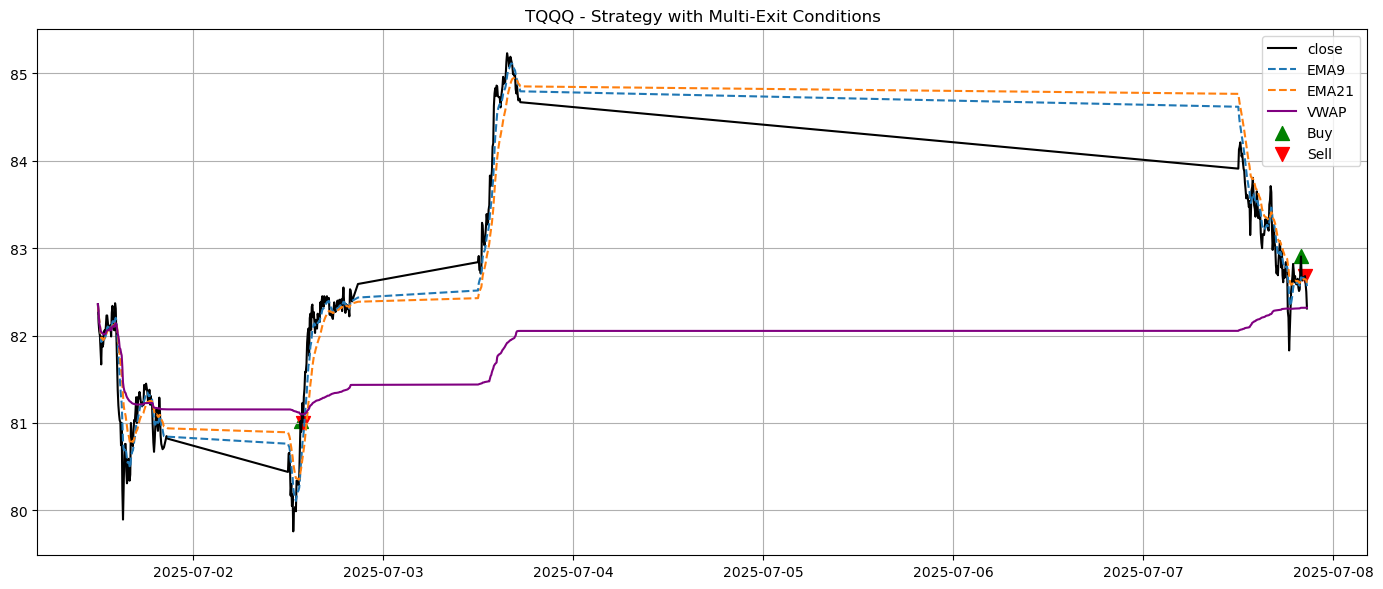

In [7]:
from utils_day_trade import generate_signals_and_backtest, get_latest_data
import pytz
df = get_latest_data(ticker)
eastern = pytz.timezone('US/Eastern')
df, trades = generate_signals_and_backtest(df)
    

results = pd.DataFrame(trades)
if not results.empty:
    print("🔎 回测总结")
    print(results)
    recent_buys = df[df["signal"] == 1].tail(5)
    recent_sells = df[df["sell_signal"] == -1].tail(5)

    print("\n📋 Recent Buy Signals:")
    for _, row in recent_buys.iterrows():
        dt = row["timestamp"] if "timestamp" in row else row["Datetime"]
        dt = pd.to_datetime(dt)
        dt_eastern = dt.astimezone(eastern)
        print(f"🟢 {dt_eastern.strftime('%Y-%m-%d %H:%M:%S %Z')} @ {row['open']:.2f}")

    print("\n📋 Recent Sell Signals:")
    for _, row in recent_sells.iterrows():
        dt = row["timestamp"] if "timestamp" in row else row["Datetime"]
        dt = pd.to_datetime(dt)
        dt_eastern = dt.astimezone(eastern)
        print(f"🔴 {dt_eastern.strftime('%Y-%m-%d %H:%M:%S %Z')} @ {row['close']:.2f}")
    print(f"✅ 总交易次数: {len(results)}")
    print(f"🏆 胜率: {round((results['Return'] > 0).sum() / len(results) * 100, 2)}%")
    print(f"📈 总收益: {round(results['Return'].sum() * 100, 2)}%")
    print(f"💰 每笔平均收益: {round(results['Return'].mean() * 100, 2)}%")


# 提取买卖点
buy_signals = df[df["signal"] == 1]
sell_signals = df[df["sell_signal"] == -1]

# 绘图展示
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="close", color="black")
plt.plot(df.index, df["ema9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["ema21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["vwap"], label="VWAP", color="purple")
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell", s=100)
plt.title(f"{ticker} - Strategy with Multi-Exit Conditions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3 bars delay

🔎 回测总结
                   Buy_Time                 Sell_Time  Buy_Price  Sell_Price  \
0 2025-07-02 13:50:00+00:00 2025-07-02 14:10:00+00:00      81.05      81.585   
1 2025-07-07 20:10:00+00:00 2025-07-07 20:35:00+00:00      82.60      82.500   

     Return                         Stop_Loss_Reasons  
0  0.006601                                       NaN  
1 -0.001211  EMA9 < EMA21; RSI < 50; No rise in 15min  

📋 Recent Buy Signals:
🟢 2025-07-02 09:50:00 EDT @ 81.05
🟢 2025-07-07 16:10:00 EDT @ 82.60

📋 Recent Sell Signals:
🔴 2025-07-02 10:10:00 EDT @ 81.58
🔴 2025-07-07 16:35:00 EDT @ 82.50
✅ 总交易次数: 2
🏆 胜率: 50.0%
📈 总收益: 0.54%
💰 每笔平均收益: 0.27%


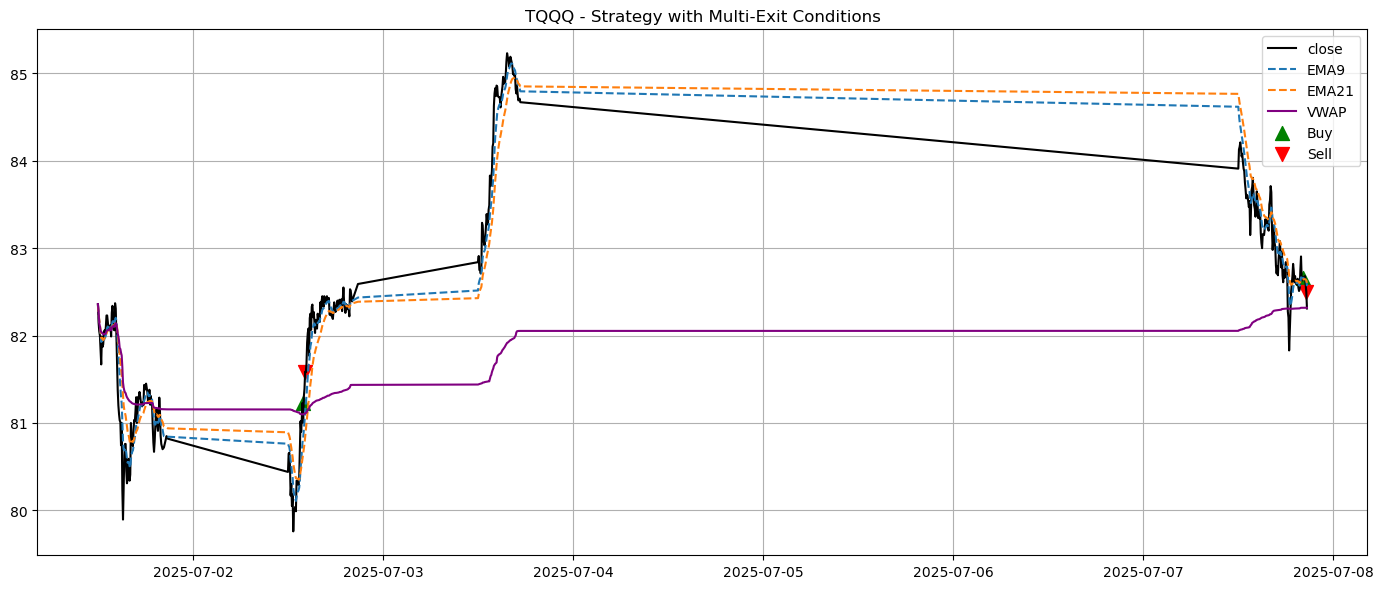

In [9]:

# # 买入逻辑
# df["Signal"] = 0
# df["up1"] = df["close"].diff(1).shift(1) > 0
# df["up2"] = df["close"].diff(1).shift(2) > 0
# df["VolUp"] =  df["volume"].shift(1) > df["volume"].shift(2)

# signal_condition = (
#     (df["EMA9"] > df["EMA21"]) &
#     (df["EMA9"].shift(1) <= df["EMA21"].shift(1)) &
#     (df["RSI"].between(50, 70)) &
#     (df["up1"]) & (df["up2"]) & (df["VolUp"])
# )

# df.loc[signal_condition.shift(3, fill_value=False), "Signal"] = 1


# df["Sell_Signal"] = 0
# holding = False
# buy_price = 0
# buy_time = None
# trades = []

# for i in range(len(df)):
#     if i < 3:
#         continue  # 前3个bar跳过，因为无法滞后3位
#     row = df.iloc[i]
#     time = row.name

#     # 延迟3根bar后的买入
#     if df["Signal"].iloc[i - 3] == 1 and not holding:
#         holding = True
#         buy_price = row["open"]
#         buy_time = time
#         buy_datetime = row['timestamp']
#         continue

#     if holding:
#         current_price = row["close"]
#         change_pct = (current_price - buy_price) / buy_price
#         duration = (time - buy_time) / 60 if buy_time else 0
#         vw_delta = (current_price - row["VWAP"]) / row["VWAP"]
#         rsi_prev = df["RSI"].iloc[i - 1] if i > 0 else row["RSI"]

#         # 止盈条件
#         tp1 = change_pct >= 0.015
#         tp2 = row["RSI"] > 70 and row["RSI"] < rsi_prev
#         tp3 = vw_delta > 0.025
#         if tp1 or tp2 or tp3:
#             # 延迟3根bar后的卖出
#             if i + 3 < len(df):
#                 sell_index = df.index[i + 3]
#                 df.at[sell_index, "Sell_Signal"] = -1
#                 sell_datetime = df.at[sell_index, "timestamp"]
#                 sell_price = df.at[sell_index, "close"]
#             else:
#                 df.at[time, "Sell_Signal"] = -1
#                 sell_datetime = row["timestamp"]
#                 sell_price = current_price

#             holding = False
#             if buy_datetime and sell_datetime:
#                 trades.append({
#                     "Buy_Time": buy_datetime,
#                     "Sell_Time": sell_datetime,
#                     "Buy_Price": buy_price,
#                     "Sell_Price": sell_price,
#                     "Return": (sell_price - buy_price) / buy_price
#                 })
#                 buy_datetime = None
#             continue

#         # 止损条件
#         sl_conditions = [
#             change_pct <= -0.005,
#             row["EMA9"] <= row["EMA21"],
#             row["RSI"] <= 50,
#             row["close"] < row["VWAP"],
#             duration > 15
#         ]
#         if sum(sl_conditions) >= 2:
#             if i + 3 < len(df):
#                 sell_index = df.index[i + 3]
#                 df.at[sell_index, "Sell_Signal"] = -1
#                 sell_datetime = df.at[sell_index, "timestamp"]
#                 sell_price = df.at[sell_index, "close"]
#             else:
#                 df.at[time, "Sell_Signal"] = -1
#                 sell_datetime = row["timestamp"]
#                 sell_price = current_price

#             holding = False
#             if buy_datetime and sell_datetime:
#                 trades.append({
#                     "Buy_Time": buy_datetime,
#                     "Sell_Time": sell_datetime,
#                     "Buy_Price": buy_price,
#                     "Sell_Price": sell_price,
#                     "Return": (sell_price - buy_price) / buy_price
#                 })
#                 buy_datetime = None

from utils_day_trade import generate_signals_and_backtest_delay
df = get_latest_data(ticker)
df,trades = generate_signals_and_backtest_delay(df,3)

backtest_plot(ticker,df,trades)
# results = pd.DataFrame(trades)
# if not results.empty:
#     print("🔎 回测总结")
#     print(results)
#     print(f"✅ 总交易次数: {len(results)}")
#     print(f"🏆 胜率: {round((results['Return'] > 0).sum() / len(results) * 100, 2)}%")
#     print(f"📈 总收益: {round(results['Return'].sum() * 100, 2)}%")
#     print(f"💰 每笔平均收益: {round(results['Return'].mean() * 100, 2)}%")


# # 提取买卖点
# buy_signals = df[df["Signal"] == 1]
# sell_signals = df[df["Sell_Signal"] == -1]

# # 绘图展示
# plt.figure(figsize=(14, 6))
# plt.plot(df.index, df["close"], label="close", color="black")
# plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
# plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
# plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
# plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy", s=100)
# plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell", s=100)
# plt.title(f"{ticker} - Strategy with Multi-Exit Conditions")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()